# Transforming workflow for coeanography study using S2 data, from SAFE to ZARR

This is a part of  notebook which we will show the example of transformation of research workflow using SAFE file format to new EOPF ZARR format. 


We use example from a repository https://github.com/cuevas-a97/S2_Codes , which shows the computation of oceanic current using S2L1C images. 

To understand the scientific background of this notebook, please reffer to https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012425

This notebook  show the workflow using zarr format.  

All the research sofware that was used in https://github.com/cuevas-a97/S2_Codes, can also be omitted since the new zarr product already can load necessary data with the functionality available from EOPF zarr format.  

You can test this notebook using following docker image

> docker.io/tinaok/eopf-webiner6-docker:latest



In [ ]:

!mamba  install xarray-eopf -y  

## Access the Analysisi Ready Clowed Optimised EOPF ZARR  file
### Import dependencies accessing the  EOPF ZARR format. 

It is very easy. I used EOPF Sample service example notebook and just copied pasted some cells. 
https://eopf-sample-service.github.io/eopf-sample-notebooks/stac-eopf-zarr-sentinel



In [1]:
#import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from pystac_client import CollectionSearch
#from matplotlib.gridspec import GridSpec
import hvplot.xarray

### Use pystac client and connect to the eopf zarr data

In [17]:
#lets try to specify 'ocean' point and see if we have any specific metadta to collect 'ocean' parts from stac catalog,

catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
LON, LAT = -4.5, 48

date = "2025-07-07/2025-07-11"
date = "2025-01-01/2025-03-01"

collections=['sentinel-2-l1c']
#collections=['sentinel-2-l2a']

#collections=['sentinel-2-l1c','sentinel-2-l2a']
# Search with cloud cover filter
items = list(
    catalog.search(
#        datetime=date,
        collections=collections,
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    ).items()
)

for item in items:
        print(f"✅ {item.id}")
    # Print properties clearly
        #print("Metadata properties:\n")
        #for key, value in item.properties.items():
        #    print(f"- {key}: {value}")   

✅ S2B_MSIL1C_20250717T112119_N0511_R037_T30UUU_20250717T131758
✅ S2A_MSIL1C_20250714T112131_N0511_R037_T30UUU_20250714T135220
✅ S2B_MSIL1C_20250707T112119_N0511_R037_T30UUU_20250707T131612
✅ S2A_MSIL1C_20250704T112131_N0511_R037_T30UUU_20250704T150040
✅ S2C_MSIL1C_20250702T112141_N0511_R037_T30UUU_20250702T134437
✅ S2B_MSIL1C_20250627T112119_N0511_R037_T30UUU_20250627T131553
✅ S2A_MSIL1C_20250624T112131_N0511_R037_T30UUU_20250624T135219
✅ S2C_MSIL1C_20250622T112131_N0511_R037_T30UUU_20250622T120825
✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418
✅ S2A_MSIL1C_20250614T112131_N0511_R037_T30UUU_20250614T145517
✅ S2C_MSIL1C_20250612T112131_N0511_R037_T30UUU_20250612T131903
✅ S2B_MSIL1C_20250607T112109_N0511_R037_T30UUU_20250607T131528
✅ S2A_MSIL1C_20250604T112131_N0511_R037_T30UUU_20250604T135331
✅ S2C_MSIL1C_20250602T112131_N0511_R037_T30UUU_20250602T131953
✅ S2B_MSIL1C_20250528T112119_N0511_R037_T30UUU_20250528T131527
✅ S2A_MSIL1C_20250525T112131_N0511_R037_T30UUU_20250525

In [ ]:
import pandas as pd

records = []

for item in items:
    props = item.properties
    records.append({
        "id": item.id,
        "datetime": props.get("datetime"),
        "start_datetime": props.get("start_datetime"),
        "platform": props.get("platform"),
        "constellation": props.get("constellation"),
        "processing:level": props.get("processing:level"),
        "processing:lineage": props.get("processing:lineage"),
        "product:timeliness": props.get("product:timeliness"),
        "sat:orbit_state": props.get("sat:orbit_state"),
        "sat:absolute_orbit": props.get("sat:absolute_orbit"),
        "sat:relative_orbit": props.get("sat:relative_orbit"),
        "eo:cloud_cover": props.get("eo:cloud_cover"),
        "eo:snow_cover": props.get("eo:snow_cover"),
        "view:sun_azimuth": props.get("view:sun_azimuth"),
        "view:sun_elevation": props.get("view:sun_elevation"),
        "grid:code": props.get("grid:code"),
        "mgrs:utm_zone": props.get("mgrs:utm_zone"),
        "mgrs:latitude_band": props.get("mgrs:latitude_band"),
        "mgrs:grid_square": props.get("mgrs:grid_square"),
        "proj:centroid_lon": props.get("proj:centroid", {}).get("lon"),
        "proj:centroid_lat": props.get("proj:centroid", {}).get("lat"),
    })

df = pd.DataFrame(records)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").set_index("datetime")
#df = df.set_index("datetime")  # Set datetime as index for easier plotting
df

In [ ]:
import hvplot.xarray

ds = xr.Dataset.from_dataframe(df)
ds["view:sun_elevation"].hvplot(kind='scatter',marker='o', figsize=(10, 5))

In [32]:
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

# Plot 1: Cloud Cover (left y-axis)
cloud_plot = ds["eo:cloud_cover"].hvplot.scatter(
    label='Cloud Cover (%)',
    color='blue',
    ylabel='Cloud Cover (%)',
    width=800,
    height=400,
    marker='o'
)

# Plot 2: Sun Elevation (right y-axis)
sun_plot = ds["view:sun_elevation"].hvplot.scatter(
    label='Sun Elevation (°)',
    color='orange',
    yaxis='right',
    ylabel='Sun Elevation (°)',
    width=800,
    height=400,
    marker='x'
)

# Combine both plots
cloud_plot * sun_plot

:Overlay
   .Scatter.Cloud_Cover_left_parenthesis_percent_right_parenthesis  :Scatter   [datetime]   (eo:cloud_cover)
   .Scatter.Sun_Elevation_left_parenthesis_degree_right_parenthesis :Scatter   [datetime]   (view:sun_elevation)

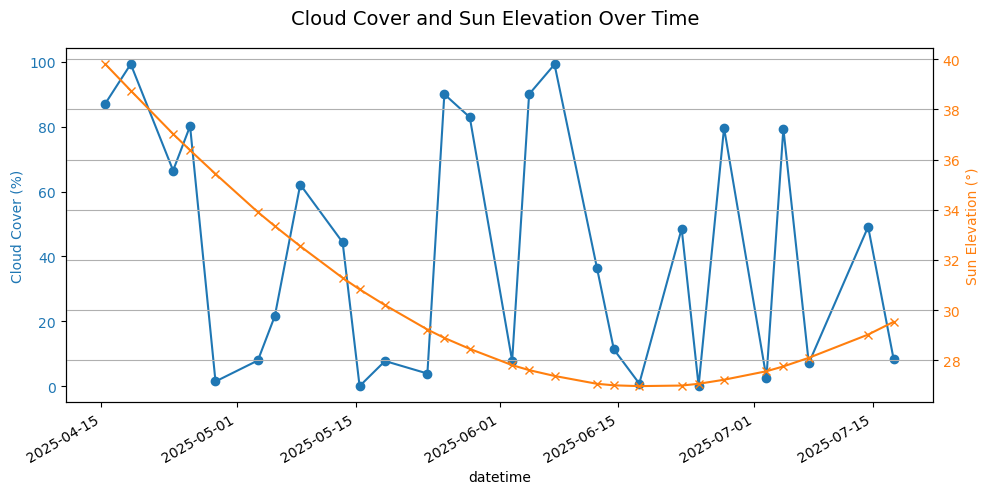

In [31]:
import matplotlib.pyplot as plt

# Make sure datetime is index
df_plot = df.copy()
df_plot = df_plot.sort_index()

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left y-axis: Cloud Cover
color1 = "tab:blue"
df_plot["eo:cloud_cover"].plot(ax=ax1, color=color1, marker='o', label="Cloud Cover (%)")
ax1.set_ylabel("Cloud Cover (%)", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Right y-axis: Sun Elevation
ax2 = ax1.twinx()
color2 = "tab:orange"
df_plot["view:sun_elevation"].plot(ax=ax2, color=color2, marker='x', label="Sun Elevation (°)")
ax2.set_ylabel("Sun Elevation (°)", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
fig.suptitle("Cloud Cover and Sun Elevation Over Time", fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()